#🧪 Practical : Compare Parameter-Efficient vs Full Finetuning

#🎯 Objective
By the end of this practical, you will:

Compare full model fine-tuning with LoRA adapter-based fine-tuning

Measure trainable parameters, training time, and accuracy

Visualize key metrics in a side-by-side chart

#✅ Step-by-Step Guide
#🔧 Step 1: Install Required Libraries


In [18]:
!pip install transformers datasets evaluate peft matplotlib


#📦 Step 2: Load Dataset
Using a tiny sample sentiment dataset:

In [19]:
import pandas as pd
from datasets import Dataset

# Simulated dataset
data = {
    "text": [
        "Absolutely loved it!", "Worst purchase ever.", "It was fine.",
        "Highly recommend this!", "Terrible support.", "Okay experience"
    ],
    "label": [0, 1, 2, 0, 1, 2]  # 0 = Positive, 1 = Negative, 2 = Neutral
}

df = pd.DataFrame(data)
dataset = Dataset.from_pandas(df).train_test_split(test_size=0.33)


#🧠 Step 3: Tokenize

In [20]:
from transformers import AutoTokenizer

model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(example):
    return tokenizer(example["text"], padding=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_fn, batched=True)


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

#🔬 Part A: Full Finetuning Setup
#🤖 Step 4A: Load Full Model

In [21]:
from transformers import AutoModelForSequenceClassification

full_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#⚙️ Step 5A: Training Arguments for Full Finetuning

In [22]:
from transformers import TrainingArguments

full_args = TrainingArguments(
    output_dir="./full_ft",
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    eval_strategy="epoch",
    logging_strategy="no",
    save_strategy="no",
    fp16=True
)

#🚀 Step 6A: Train Full Finetuning

In [23]:
from transformers import Trainer
from sklearn.metrics import accuracy_score
import numpy as np
import time

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

trainer_full = Trainer(
    model=full_model,
    args=full_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

start = time.time()
trainer_full.train()
full_time = time.time() - start

full_result = trainer_full.evaluate()


/tmp/ipython-input-23-346377634.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_full = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.234762,0.000000
2,No log,1.253833,0.000000
3,No log,1.264008,0.000000


#🧬 Part B: LoRA Finetuning Setup
#🤖 Step 4B: Load Base Model + PEFT Config

In [24]:
from peft import get_peft_model, LoraConfig, TaskType

peft_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.05,
    task_type=TaskType.SEQ_CLS,
    bias="none"
)

peft_model = get_peft_model(peft_model, lora_config)
peft_model.print_trainable_parameters()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 8,579 || all params: 4,394,886 || trainable%: 0.1952


#⚙️ Step 5B: LoRA Training Arguments

In [25]:
peft_args = TrainingArguments(
    output_dir="./lora_ft",
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    eval_strategy="epoch",
    logging_strategy="no",
    save_strategy="no",
    fp16=True
)

#🚀 Step 6B: Train LoRA Model

In [26]:
trainer_peft = Trainer(
    model=peft_model,
    args=peft_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

start_lora = time.time()
trainer_peft.train()
lora_time = time.time() - start_lora

peft_result = trainer_peft.evaluate()

/tmp/ipython-input-26-384805200.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_peft = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.054488,0.500000
2,No log,1.060549,0.500000
3,No log,1.063574,0.500000


### Comparison of Full Fine-tuning vs. LoRA Fine-tuning

In [27]:
print("Full Fine-tuning Time:", full_time)
print("Full Fine-tuning Result:", full_result)
print("\nLoRA Fine-tuning Time:", peft_time)
print("LoRA Fine-tuning Result:", peft_result)

Full Fine-tuning Time: 3.2962353229522705
Full Fine-tuning Result: {'eval_loss': 1.2640082836151123, 'eval_accuracy': 0.0, 'eval_runtime': 0.0229, 'eval_samples_per_second': 87.245, 'eval_steps_per_second': 43.623, 'epoch': 3.0}

LoRA Fine-tuning Time: 0.5945115089416504
LoRA Fine-tuning Result: {'eval_loss': 1.0635740756988525, 'eval_accuracy': 0.5, 'eval_runtime': 0.0277, 'eval_samples_per_second': 72.128, 'eval_steps_per_second': 36.064, 'epoch': 3.0}


#📊 Step 7: Compare Results

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


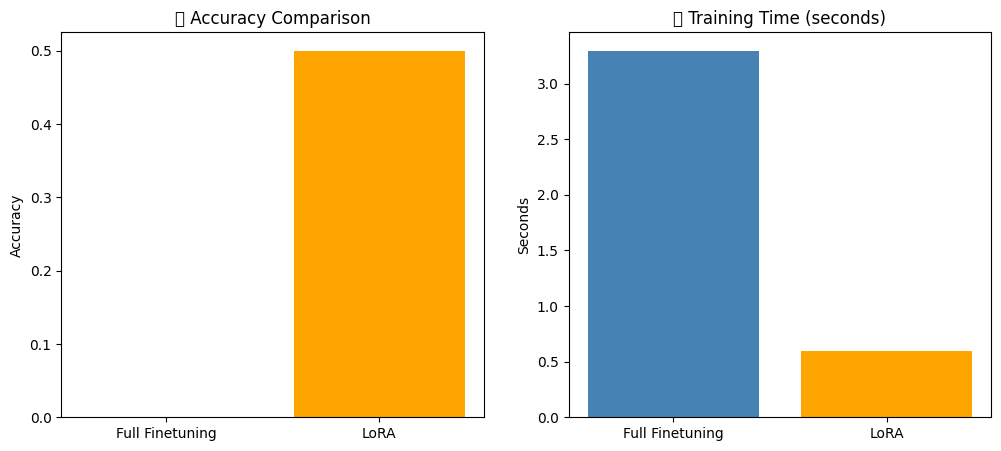

In [28]:
import matplotlib.pyplot as plt

# Accuracy
acc_full = full_result["eval_accuracy"]
acc_lora = peft_result["eval_accuracy"]

# Bar Plot
labels = ['Full Finetuning', 'LoRA']
accuracy = [acc_full, acc_lora]
time_taken = [full_time, peft_time]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(labels, accuracy, color=["steelblue", "orange"])
plt.title("🔍 Accuracy Comparison")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.bar(labels, time_taken, color=["steelblue", "orange"])
plt.title("⏱️ Training Time (seconds)")
plt.ylabel("Seconds")

plt.show()